실험 전 데이터 파일 업로드

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
!unzip -qq 양돈과_최요한.zip

In [ ]:
!ls

# 과적합(Overfitting)

**과소적합(Underfitting)**

- 모델이 (단순하여) 충분히 학습하지 못한 상태
- 학습 성능과 테스트 성능 모두 낮음
- 예: 선형 모델로 복잡한 데이터 및 문제 학습
- 개선: 더 깊고 큰 모델, 학습 시간(epoch)·배치 크기 늘리기, 더 큰 LR

**과적합(Overfitting)**

- 모델이 너무 크고 복잡하여 데이터에 과적합된 상태(학습데이터를 지나치게 많이 학습)
- 학습 성능은 높지만 테스트 성능이 낮음

**오버피팅 개 방법**
1. 데이터 증강(Data augmentation)
2. 모델 복잡도 줄이기
3. 가중치 규제(Regularization) 적용
4. Dropout


# Torchvision을 이용한 돼지 초음파 영상 데이터셋에서의 객체 검출의 오버피팅 해결

객체 검출에서는 공간 정보가 손실될 수 있기 때문에 일반적으로 Dropout을 사용하지 않습니다.

**2. 데이터 증강**과 **3. 가중치 감쇠(Weight decay) & 배치 정규화(Batch normalization)**를 사용해 오버피팅을 해결해 보겠습니다.

## Data augmentation

기존 데이터셋 정의 코드에 데이터 증강을 추가합니다.

검출 문제는 이미지와 바운딩 박스 좌표를 함께 바꾸어야하기 때문에, 편의를 위해 외부 라이브러리 `Albumentations`를 사용합니다.

`torchvision`만으로도 구현 가능하지만 복잡한 계산 혹은 실험 버전의 설치가 필요합니다.

자주 쓰이는 증강 기법 및 `albumentations` 라이브러리 함수

| Transform                  | 설명                                 | 주요 파라미터 예시                                                          |
| -------------------------- | ---------------------------------- | ------------------------------------------------------------------- |
| `HorizontalFlip`           | 이미지를 좌우로 뒤집음                       | `p=0.5`                                                             |
| `VerticalFlip`             | 이미지를 상하로 뒤집음                       | `p=0.5`                                                             |
| `RandomRotate90`           | 90° 단위로 랜덤 회전                      | `p=0.5`                                                             |
| `Rotate`                   | 임의 각도로 회전                          | `limit=±15` (`limit=(-15,15)`), `p=0.5`                             |
| `RandomResizedCrop`        | 랜덤 위치에서 크롭 후 지정 크기로 리사이즈           | `height=224, width=224, scale=(0.8,1.0)`                            |
| `ShiftScaleRotate`         | 이동·스케일·회전을 복합 적용                   | `shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5`          |
| `RandomBrightnessContrast` | 밝기와 대비를 랜덤하게 조절                    | `brightness_limit=0.2, contrast_limit=0.2, p=0.5`                   |
| `HueSaturationValue`       | 색조·채도·명도를 랜덤하게 조절                  | `hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5` |
| `GaussianBlur`             | 가우시안 블러 적용                         | `blur_limit=(3,7), p=0.3`                                           |
| `GaussNoise`               | 가우시안 노이즈 추가                        | `var_limit=(10.0, 50.0), p=0.3`                                     |
| `RandomGamma`              | 감마 보정                              | `gamma_limit=(80,120), p=0.5`                                       |
| `Cutout` / `CoarseDropout` | 이미지 일부 영역을 랜덤하게 지워 노이즈 또는 결측 효과 모방 | `max_holes=8, max_height=16, max_width=16, p=0.5`                   |
| `Normalize`                | 이미지 픽셀 정규화 (mean/std)              | `mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)`                 |


### 데이터셋 클래스 정의

초음파 이미지에 적합한 다음의 증강을 추가합니다.

- HorizontalFlip, RandomResizedCrop, Rotate, ShiftScaleRotate, MultiplicativeNoise




필요 라이브러리 불러오기

In [2]:
import os, glob
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

데이터셋 클래스

사용 함수와 옵션
* `HorizontalFlip(p=0.5)`: 50% 확률로 좌우 반전
* `RandomResizedCrop(224, 224, scale=(0.8, 1.0), p=0.5)`: 50% 확률로 원본의 80%–100% 영역을 랜덤 크롭 후 224×224로 리사이즈
* `Rotate(limit=15, p=0.5)`: 50% 확률로 –15°\~+15° 사이의 각도로 랜덤 회전
* `ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5)`: 50% 확률로 가로·세로 최대 ±10% 이동 및 90%–110% 크기 조절 (회전 제외)
* `MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5)`: 50% 확률로 픽셀 값에 0.9–1.1 배수 노이즈 곱셈 (스펙클 유사)
* `ToTensorV2()`: 이미지를 `(C, H, W)` FloatTensor로 변환하고 `[0,1]` 범위로 정규화
* `bbox_params=A.BboxParams(format='yolo', label_fields=['labels'])`: 바운딩 박스가 픽셀 좌표 `[xc,yc,w,h]` 포맷임을 지정하고, 레이블과 함께 자동 변형 적용

In [10]:
class PigDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        """
        Args:
            root_dir (str): '양돈과_최요한' 최상위 폴더 경로
            augment (bool): True면 데이터 증강, False면 resize, normalization 후 tensor 변환
        """

        # 1) 증강 및 전처리
        if augment:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomResizedCrop(size=(224, 224), scale=(0.8,1.0), p=0.5),
                A.Rotate(limit=15, p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
                A.MultiplicativeNoise(multiplier=(0.9,1.1), p=0.5),

                A.Resize(height=224, width=224),
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0),
                ToTensorV2(),
            ], bbox_params=A.BboxParams(
                format='yolo',            # YOLO 정규화 포맷: [x_center, y_center, w, h]
                label_fields=['labels']
            ))
        else:
            self.transform = A.Compose([
                A.Resize(224, 224),
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0),
                ToTensorV2(),
            ], bbox_params=A.BboxParams(
                format='yolo',
                label_fields=['labels']
            ))

        # 2) 레이블 파일이 있는 이미지 모음
        pattern = os.path.join(root_dir, '*', '*.bmp')
        all_bmps = glob.glob(pattern)
        self.img_files = [p for p in all_bmps if os.path.exists(p[:-4] + '.txt')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        # 1) 이미지 로드 및 nparray로 변환
        img = np.array(Image.open(img_path).convert("RGB"))
        orig_h, orig_w, _ = img.shape  # height, width

        # 2) YOLO 포맷의 레이블 파일 로드
        bboxes, labels = [], []
        txt_path = img_path[:-4] + '.txt'
        with open(txt_path, 'r') as f:
            for line in f:
                cls, x_c, y_c, w, h = map(float, line.strip().split())
                bboxes.append([x_c, y_c, w, h])
                labels.append(int(cls) + 1)  # +1 offset: 0→background

        # 3) 증강 적용
        augmented = self.transform(image=img, bboxes=bboxes, labels=labels)
        img_t       = augmented['image']        # Tensor (3,224,224)
        bboxes_norm = augmented['bboxes']       # list [cx,cy,w,h]
        labels_t    = torch.tensor(augmented['labels'], dtype=torch.int64)

        # 4) 224×224 기준 YOLO → 픽셀 좌표 [x1,y1,x2,y2] 변환
        H, W = img_t.shape[1], img_t.shape[2]
        boxes = []
        for x_c, y_c, w_box, h_box in bboxes_norm:
            x1 = (x_c - w_box/2) * W
            y1 = (y_c - h_box/2) * H
            x2 = (x_c + w_box/2) * W
            y2 = (y_c + h_box/2) * H
            boxes.append([x1, y1, x2, y2])

        if len(boxes) == 0:
            boxes_t  = torch.zeros((0, 4), dtype=torch.float32)  # [0,4]
            labels_t = torch.zeros((0,),    dtype=torch.int64)    # [0]
        else:
            boxes_t  = torch.tensor(boxes, dtype=torch.float32)  # [N,4]
            labels_t = torch.tensor(labels,      dtype=torch.int64)    # [N]

        target = {'boxes': boxes_t, 'labels': labels_t}

        return img_t, target


### 학습

증강된 데이터셋을 이용해 모델을 학습합니다.

In [11]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import tqdm
import matplotlib.pyplot as plt

In [12]:
# 디바이스
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


In [13]:
# 하이퍼파라미터
class_num = 2        # 클래스 개수: torchvison에서는 0은 배경으로 고정이기 때문에 클래스 개수 + 1
batch_size = 4         # 배치 크기
learning_rate = 0.001    # 학습률
num_epochs = 10           # 에포크 수

In [ ]:
# 데이터셋 로드 및 스플릿

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = PigDataset(
    root_dir='/content/양돈과_최요한',
    augment=True)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size   = total_size - train_size

train_ds, val_ds = random_split(
    dataset,
    [train_size, val_size]
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,     # validation은 shuffle=False 권장
    collate_fn=collate_fn
)

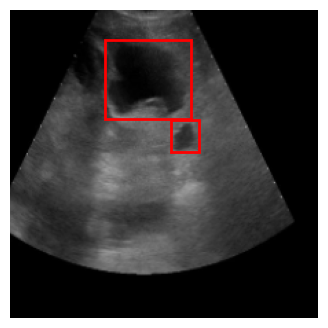

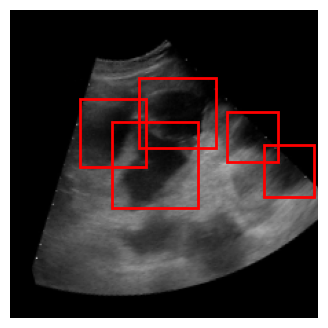

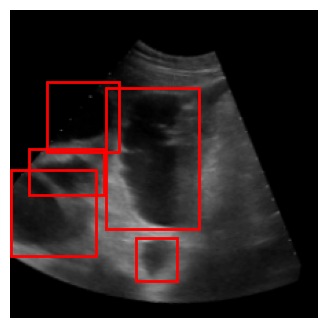

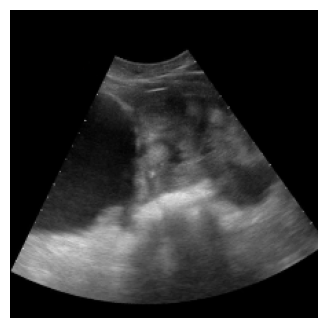

In [15]:
# 샘플 배치 확인
# 이미지가 조금씩 변형된 것을 확인

imgs, targets = next(iter(train_loader))

for i in range(batch_size):
    img = imgs[i]
    boxes = targets[i]['boxes']

    # (C,H,W) → (H,W,C) → numpy
    img = img.permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    ax = plt.gca()
    for x1,y1,x2,y2 in boxes:
        rect = plt.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            edgecolor='r', facecolor='none', linewidth=2
        )
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

기존 실습과 동일한 모델과 옵티마이저로 학습합니다.

In [16]:
# ResNet-50을 백본으로 하는 Faster R-CNN
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 사용 데이터에 맞게 헤더 변경
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=class_num)

model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=0.0005
)


train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Train ------------------------

    model.train() # train 모드

    epoch_loss = 0.0
    for images, targets in tqdm.tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", ncols=100):
        # device로 옮기기
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # forward pass & loss dict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # backward & update
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation ---------------------

    epoch_val_loss = 0.0
    with torch.no_grad(): # eval에서는 gradient 계산 안함
        for images, targets in tqdm.tqdm(val_loader, desc=f"[Val]   Epoch {epoch+1}/{num_epochs}", ncols=100):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")



[Val]   Epoch 1/10: 100%|█████████████████████████████████████████████| 7/7 [00:17<00:00,  2.57s/it]


Epoch 1/10  Train Loss: 0.5546  Val Loss: 0.4957


[Val]   Epoch 2/10: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.92it/s]


Epoch 2/10  Train Loss: 0.4999  Val Loss: 0.3843


[Val]   Epoch 3/10: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.75it/s]


Epoch 3/10  Train Loss: 0.3486  Val Loss: 0.3069


[Val]   Epoch 4/10: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.86it/s]


Epoch 4/10  Train Loss: 0.3017  Val Loss: 0.2698


[Val]   Epoch 5/10: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.92it/s]


Epoch 5/10  Train Loss: 0.2726  Val Loss: 0.2608


[Val]   Epoch 6/10: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch 6/10  Train Loss: 0.2549  Val Loss: 0.2817


[Val]   Epoch 7/10: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.93it/s]


Epoch 7/10  Train Loss: 0.2502  Val Loss: 0.2606


[Val]   Epoch 8/10: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch 8/10  Train Loss: 0.2473  Val Loss: 0.2642


[Val]   Epoch 9/10: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.71it/s]


Epoch 9/10  Train Loss: 0.2469  Val Loss: 0.2467


[Val]   Epoch 10/10: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.77it/s]

Epoch 10/10  Train Loss: 0.2237  Val Loss: 0.2421


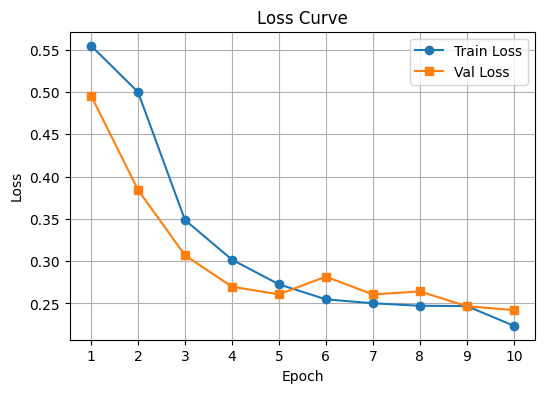

In [17]:
# Loss curve

plt.figure(figsize=(6,4))
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='s', label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

In [18]:
# Evaluation

from torchvision.ops import box_iou

def evaluate_dataset(model, data_loader, device, iou_thresh=0.5, score_thresh=0.5):
    """
    모델과 DataLoader를 받아 Validation Precision & Recall 계산.
    """
    tp = fp = fn = 0
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images   = [img.to(device) for img in images]
            gt_boxes = [t['boxes'].to(device) for t in targets]
            gt_labels= [t['labels'].to(device) for t in targets]

            outputs = model(images)
            for output, gt_b, gt_l in zip(outputs, gt_boxes, gt_labels):
                tidx = output['scores'] >= score_thresh
                pred_boxes  = output['boxes'][tidx]
                pred_labels = output['labels'][tidx]

                # 1) GT가 없으면, 모든 예측은 False Positive
                if gt_b.numel() == 0:
                    fp += pred_boxes.shape[0]
                    continue
                # 2) 예측이 없으면, 모든 GT는 False Negative
                if pred_boxes.numel() == 0:
                    fn += gt_b.shape[0]
                    continue

                # 3) IoU 매트릭스 계산
                ious = box_iou(pred_boxes, gt_b)  # [P, G]

                # 4) 예측 박스마다 TP/FP 결정
                matched_gt = torch.zeros(gt_b.size(0), dtype=torch.bool, device=device)
                for i in range(pred_boxes.size(0)):
                    max_iou, idx = ious[i].max(0)
                    if max_iou >= iou_thresh and pred_labels[i] == gt_l[idx]:
                        tp += 1
                        matched_gt[idx] = True
                    else:
                        fp += 1
                # 5) 매칭되지 않은 GT는 FN
                fn += (~matched_gt).sum().item()

    precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
    recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0
    return precision, recall


In [19]:
precision, recall = evaluate_dataset(model, val_loader, device)
print(f"Precision: {precision:.4f}  Recall: {recall:.4f}")

Precision: 0.6404  Recall: 0.9048


### 결과 비교

- 최종 validation loss의 감소
- 학습 초반 epoch에 validation loss가 크게 떨어져 training loss를 따라잡는 모습이 뚜렷해짐
- 학습 중반 이후에도 0에 수렴하며 오버피팅 징후가 크게 줄어듦
- 높은 recall: 모델이 훨씬 다양한 데이터를 학습하면서 FN(False negative)가 감소(객체를 놓치는 경우가 줄어듦)

***하지만*** 아직 더 개선할 점
- validation loss가 완벽한 수렴이 아님
- Precision이 상대적으로 낮음

  = FP(False positive)가 증가(목표가 아닌 것을 잘못 검출)


**어떻게 해결할까?**
- Augmentaiton 조절
- Weight decay, normalization, optimizer 변경 등의 Regularizaiton
- Learning rate 스케줄링
- 백본 변경(좀 더 성능 좋은 모델로)

## Regularization

앞서 생성한 `PigDataset`과 `train_loader`, `val_loader`를 그대로 사용하면서 **weight decay**, **batch normalization**(기본 모델에 적용),  **LR 스케줄링**을 적용해 결과를 비교합니다.

In [46]:
# 적용 부분만 주석

import torch
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import StepLR
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 하이퍼파라미터
learning_rate = 0.001
num_epochs = 20

# 모델
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=class_num)
model.to(device)

# 옵티마이저
optimizer = SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=1e-4   # weight decay 적용
)

# LR 스케줄러
scheduler = StepLR(  # 계단형으로 lr이 감소하는 가장 기본적인 스케줄러
    optimizer,
    step_size=10,   # step_size 에폭마다
    gamma=0.1      # lr *= 0.1
)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
# 학습
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Train ------------------------

    model.train()

    epoch_loss = 0.0
    for images, targets in tqdm.tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", ncols=100):

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # LR 스케줄러 갱신
    scheduler.step()

    # Validation ---------------------

    epoch_val_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm.tqdm(val_loader, desc=f"[Val]   Epoch {epoch+1}/{num_epochs}", ncols=100):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")



[Val]   Epoch 1/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]


Epoch 1/20  Train Loss: 0.5711  Val Loss: 0.5177


[Val]   Epoch 2/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.72it/s]


Epoch 2/20  Train Loss: 0.4720  Val Loss: 0.3825


[Val]   Epoch 3/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.82it/s]


Epoch 3/20  Train Loss: 0.3466  Val Loss: 0.3075


[Val]   Epoch 4/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.75it/s]


Epoch 4/20  Train Loss: 0.2995  Val Loss: 0.3118


[Val]   Epoch 5/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch 5/20  Train Loss: 0.2811  Val Loss: 0.2740


[Val]   Epoch 6/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.17it/s]


Epoch 6/20  Train Loss: 0.2645  Val Loss: 0.2512


[Val]   Epoch 7/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.70it/s]


Epoch 7/20  Train Loss: 0.2594  Val Loss: 0.2357


[Val]   Epoch 8/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.61it/s]


Epoch 8/20  Train Loss: 0.2636  Val Loss: 0.2388


[Val]   Epoch 9/20: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  8.68it/s]


Epoch 9/20  Train Loss: 0.2340  Val Loss: 0.2469


[Val]   Epoch 10/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.52it/s]


Epoch 10/20  Train Loss: 0.2377  Val Loss: 0.2384


[Val]   Epoch 11/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.69it/s]


Epoch 11/20  Train Loss: 0.2204  Val Loss: 0.2390


[Val]   Epoch 12/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch 12/20  Train Loss: 0.2179  Val Loss: 0.2372


[Val]   Epoch 13/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  9.02it/s]


Epoch 13/20  Train Loss: 0.2180  Val Loss: 0.2456


[Val]   Epoch 14/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  9.14it/s]


Epoch 14/20  Train Loss: 0.2061  Val Loss: 0.2281


[Val]   Epoch 15/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch 15/20  Train Loss: 0.2081  Val Loss: 0.2472


[Val]   Epoch 16/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch 16/20  Train Loss: 0.2117  Val Loss: 0.2574


[Val]   Epoch 17/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  9.03it/s]


Epoch 17/20  Train Loss: 0.2195  Val Loss: 0.2281


[Val]   Epoch 18/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.94it/s]


Epoch 18/20  Train Loss: 0.2043  Val Loss: 0.2439


[Val]   Epoch 19/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.61it/s]


Epoch 19/20  Train Loss: 0.2008  Val Loss: 0.2463


[Val]   Epoch 20/20: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]

Epoch 20/20  Train Loss: 0.2065  Val Loss: 0.2408


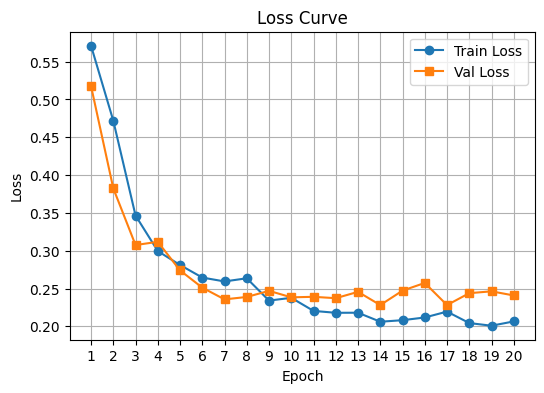

In [48]:
# Loss curve

plt.figure(figsize=(6,4))
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='s', label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

In [49]:
# 위에서 이미 정의된 eval 함수 이용

precision, recall = evaluate_dataset(model, val_loader, device)
print(f"Precision: {precision:.4f}  Recall: {recall:.4f}")

Precision: 0.6782  Recall: 0.9219


### 결과

optimizer 종류, lr, momentum, lr_scheduler, epoch 수 등을 변경해가며 찾은 안정적인 조합으로 학습한 결과입니다. (모델 셀렉션 과정)

(batch 등 위에서 고정하여 바뀌지 않은 것도 있음)

학습 중반까지는 안정화되지만 15 epoch 쯤부터 val loss가 다시 상승합니다.

더 시도해 볼만한 방법들:

* 더 나은 하이퍼파라미터 조합
* Warm up
* Early stopping: validation loss가 일정 구간 상승하면 학습을 멈춰 후반부 과적합을 막습니다.
* 백본 업그레이드

딥러닝을 활용하려면 모델, 학습시간(Epoch, batch), 옵티마이저와 LR, 데이터 증강, 정규화 등을 조절해가며 최적의 모델과 성능을 찾는 과정이 필요합니다.